In [1]:
%run setup.py


/Users/yaguang/micromamba/envs/numax/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
stars = pd.read_csv(rootpath+'numax/sample/samples_rg.csv')
vrard = pd.read_csv('~/Onedrive/Work/database/catalog/vrard+16.csv')
stars = stars.merge(vrard[['KIC', 'DPi1', 'e_DPi1']], on='KIC', how='left')

idx = stars['DPi1'].notna() & stars['e_DPi1'].notna()
stars = stars[idx].reset_index(drop=True)

stars = stars.loc[idx,:].reset_index(drop=True)
modes = pd.read_csv(rootpath+'numax/sample/modes_rg.csv')

# parameter inference

In [10]:
# stars = pd.read_csv('../sample/modelling_results.csv')

sufs = ['_m0', '_m02', '_m021', '_mlnd', '_mln', '_ml', '_m', '_mn', '_mwt']
labels = [r'$\nu_{l=0}$, $L$', 
           r'$\nu_{l=0}$, $\nu_{l=2}$, $L$', 
           r'$\nu_{l=0}$, $\nu_{l=2}$, $\Delta\Pi_1$, $L$', 
           r'$L$, $\Delta\nu$, $\nu_{\rm max}$', 
           r'$L$, $\nu_{\rm max}$', 
           r'$L$',
           r'$\nu_{l=0}$, $\nu_{l=2}$, $\Delta\Pi_1$, $L$,  $\nu_{\rm max}$',
           r'$\nu_{\rm max}$',
           r'without Teff']

original_cols = ['star_mass', 'radius',  'star_age', 'Yinit', 'Zinit', 'Xinit', 'amlt', 
                 'fov_core', 'fov_shell', 'Teff', 'luminosity', 'FeH', 'numax_scaling']
to_append_cols = [t for suf in sufs for t in ['mass'+suf, 'radius'+suf, 'age'+suf, 'Yinit'+suf, 'Zinit'+suf, 'Xinit'+suf, 'amlt'+suf, 
                                              'fov_core'+suf, 'fov_shell'+suf, 'Teff'+suf, 'luminosity'+suf, 'FeH'+suf, 'numax'+suf] ]
to_append_e_cols = [t for t in ['e_'+col for col in to_append_cols] ]
to_append_other = []

keys = ['star_mass', 'radius',  'star_age', 'Yinit', 'Zinit', 'amlt', 
        'fov_core', 'fov_shell', 'Teff', 'luminosity', 'FeH', 'numax_scaling', 
        'Dnu_freq', 'delta_Pg', 'chi2_seismic_l0', 'chi2_seismic_l2', 'chi2']

def multi(inputs):
    istar, star = inputs
    filepath = rootpath+'numax/results_gaia_nu_sc/{:0.0f}/data.h5'.format(star['KIC'])
    if not os.path.exists(filepath): return [np.nan]*(len(to_append_cols)*2 + len(to_append_other))

    data = h5py.File(filepath, 'r')
    data = pd.DataFrame({key:data[key][:] for key in keys})
    data['Xinit'] = 1-data['Yinit']-data['Zinit']
    
    chi2_Teff = (data['Teff']-star['Teff'])**2.0 / star['e_Teff']**2.0
    chi2_mh = (data['FeH']-star['[M/H]'])**2.0 / star['e_[M/H]']**2.0
    chi2_lum = (data['luminosity']-star['luminosity'])**2.0 / star['e_luminosity']**2.0
    chi2_numax = (data['numax_scaling']-star['numax'])**2.0 / star['e_numax_yu']**2.0
    chi2_Dnu = (data['Dnu_freq']-star['Dnu'])**2.0 / star['e_Dnu']**2.0
    chi2_DPi = (data['delta_Pg']-star['DPi1'])**2.0 / star['e_DPi1']**2.0

    chi2_1 = data['chi2_seismic_l0'] + chi2_Teff + chi2_mh + chi2_lum
    chi2_2 = data['chi2_seismic_l0'] + data['chi2_seismic_l2'] + chi2_Teff + chi2_mh + chi2_lum
    chi2_3 = data['chi2_seismic_l0'] + data['chi2_seismic_l2'] + chi2_DPi + chi2_lum + chi2_Teff + chi2_mh  
    chi2_4 = chi2_lum + chi2_Dnu + chi2_numax + chi2_Teff + chi2_mh
    chi2_5 = chi2_lum + chi2_numax + chi2_Teff + chi2_mh
    chi2_6 = chi2_lum + chi2_Teff + chi2_mh
    chi2_7 = data['chi2_seismic_l0'] + data['chi2_seismic_l2'] + chi2_DPi + chi2_lum + chi2_Teff + chi2_mh + chi2_numax
    chi2_8 = chi2_numax + chi2_Teff + chi2_mh
    chi2_9 = data['chi2_seismic_l0'] + data['chi2_seismic_l2'] + chi2_DPi + chi2_lum + chi2_mh + chi2_numax

    vars, e_vars = [], []
    for chi2 in [chi2_1, chi2_2, chi2_3, chi2_4, chi2_5, chi2_6, chi2_7, chi2_8, chi2_9]:
        results = quantile(np.array([data[col].to_numpy() for col in original_cols]).T, (0.16, 0.5, 0.84), weights=np.exp(-chi2/2.))
        # vars.append(list(results[1,:]))
        vars.append(list(np.average(np.array([data[col].to_numpy() for col in original_cols]).T, weights=np.exp(-chi2/2.), axis=0)))
        e_vars.append(list((results[2,:] - results[0,:])/2.))
    vars = [tt for t in vars for tt in t]
    e_vars = [tt for t in e_vars for tt in t]

    return vars + e_vars

r = list(tqdm(get_context("fork").Pool(8).imap(multi, stars.loc[:].iterrows()), total=len(stars), position=0))
stars.loc[:, to_append_cols+to_append_e_cols]  = np.array(r)


100%|██████████| 341/341 [00:34<00:00,  9.96it/s]


# Figure

0

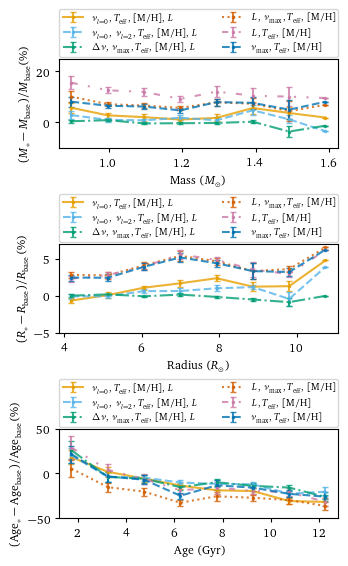

In [4]:
sufs = ['_m0', '_m02','_mlnd', '_mln', '_ml', '_mn', '_m']
labels = [r'$\nu_{l=0}, T_{\rm eff},$ [M/H], $L$', 
          r'$\nu_{l=0}$, $\nu_{l=2}, T_{\rm eff},$ [M/H], $L$',
           r'$\Delta\nu$, $\nu_{\rm max}, T_{\rm eff},$ [M/H], $L$', 
           r'$L$, $\nu_{\rm max}, T_{\rm eff},$ [M/H]', 
           r'$L, T_{\rm eff},$ [M/H]',
           r'$\nu_{\rm max}, T_{\rm eff},$ [M/H]',
           r'$\nu_{l=0}$, $\nu_{l=2}$, $\Delta\Pi_1$, $L$,  $\nu_{\rm max}$']



coeffs = np.polyfit(np.log(stars['Dnu']), np.log(stars['DPi1']), 2)
idx = (((stars['luminosity'] - stars['luminosity_m']) / stars['e_luminosity']).abs() < 4.) \
    & (((stars['numax'] - stars['numax_m']) / stars['e_numax']).abs() < 4. ) \
    & (((stars['[M/H]'] - stars['FeH_m']) / stars['e_[M/H]']).abs() < 4. ) \
    & (((stars['Teff'] - stars['Teff_m']) / stars['e_Teff']).abs() < 4. ) \
    & ( ( np.abs(stars['DPi1'] / np.exp(np.polyval(coeffs, np.log(stars['Dnu']))) - 1) ) < 0.06 ) \
    & stars['mass_m'].notna()
sample = stars[idx]

fig, axes = plt.subplots(figsize=figsize(column='one', ratio=3*0.55), nrows=3, ncols=1, squeeze=False, constrained_layout=True)
axes = axes.reshape(-1)



for isuf, suf in enumerate(sufs[:-1]):
    styles = {'linestyle': linestyles[isuf], 'ms':3, 'marker':'.', 'capsize':2, 'color':colors[isuf], 'alpha':0.8}

    x = sample['mass_m'].to_numpy()
    y = (sample[f'mass{suf:s}'].to_numpy()-sample['mass_m'].to_numpy())/x *100
    xcs, medians, stds = get_binned_median(x, y, bins=np.linspace(x.min(), x.max(), 9))
    axes[0].errorbar(xcs, medians, yerr=stds, label=labels[isuf], **styles)

    x = sample['radius_m'].to_numpy()
    y = (sample[f'radius{suf:s}'].to_numpy()-sample['radius_m'].to_numpy())/x *100
    xcs, medians, stds = get_binned_median(x, y, bins=np.linspace(x.min(), x.max(), 9))
    axes[1].errorbar(xcs, medians, yerr=stds, label=labels[isuf], **styles)

    x = sample['age_m'].to_numpy()/1e9
    y = (sample[f'age{suf:s}'].to_numpy()/1e9-sample['age_m'].to_numpy()/1e9)/x *100
    xcs, medians, stds = get_binned_median(x, y, bins=np.linspace(1, 13, 9))
    axes[2].errorbar(xcs, medians, yerr=stds, label=labels[isuf], **styles)

    # x = sample['age_m'].to_numpy()/1e9
    # y = (sample[f'Yinit{suf:s}'].to_numpy() / sample['Yinit_m'].to_numpy() - 1) * 100
    # xcs, medians, stds = get_binned_median(x, y, bins=np.linspace(0, 14, 9))
    # axes[3].errorbar(xcs, medians, yerr=stds, label=labels[isuf], **styles)

    # x = sample['age_m'].to_numpy()/1e9
    # y = (sample[f'Zinit{suf:s}'].to_numpy() / sample['Zinit_m'].to_numpy() - 1) * 100
    # xcs, medians, stds = get_binned_median(x, y, bins=np.linspace(0, 14, 9))
    # axes[4].errorbar(xcs, medians, yerr=stds, label=labels[isuf], **styles)

    # x = sample['age_m'].to_numpy()/1e9
    # y = (sample[f'Xinit{suf:s}'].to_numpy() / sample['Xinit_m'].to_numpy() - 1) * 100
    # xcs, medians, stds = get_binned_median(x, y, bins=np.linspace(0, 14, 9))
    # axes[5].errorbar(xcs, medians, yerr=stds, label=labels[isuf], **styles)

for iax in range(3):
    axes[iax].legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
                        ncols=2, mode="expand", borderaxespad=0., fontsize=fontsize-1.6)

axes[0].set_ylim(-10, 25)
axes[0].set_xlabel(r'Mass ($M_\odot$)')
axes[0].set_ylabel(r'$(M_{*} - M_{\rm base}) / M_{\rm base}$' + '(\\%)')

axes[1].set_ylim(-5, 7)
axes[1].set_xlabel(r'Radius ($R_\odot$)')
axes[1].set_ylabel(r'$(R_{*} - R_{\rm base})/ R_{\rm base}$' + '(\\%)')

axes[2].set_ylim(-50, 50)
axes[2].set_xlabel(r'Age (Gyr)')
axes[2].set_ylabel(r'$({\rm Age}_{*} - {\rm Age}_{\rm base})/ {\rm Age}_{\rm base}$' + '(\\%)')

# axes[3].set_ylim(-20, 20)
# axes[3].set_xlabel(r'Age (Gyr)')
# axes[3].set_ylabel(r'Yinit$_{*}$ / Yinit$_{\rm base}$ - 1' + '(\\%)')

# axes[4].set_ylim(-20, 20)
# axes[4].set_xlabel(r'Age (Gyr)')
# axes[4].set_ylabel(r'Zinit$_{*}$ / Zinit$_{\rm base}$ - 1' + '(\\%)')

# axes[5].set_ylim(-20, 20)
# axes[5].set_xlabel(r'Age (Gyr)')
# axes[5].set_ylabel(r'Xinit$_{*}$ / Xinit$_{\rm base}$ - 1' + '(\\%)')

filename = 'Fig.3_diff_constraints.pdf'
plt.savefig(filename, dpi=300)
os.system(to_overleaf(filename, 'figures'))

# Comparisons with previous works

In [6]:
wu = pd.read_csv('../sample/wuyq+17.csv')
wu['age_wu'] = wu['age']
wu['e_age_wu'] = wu['err_age']
wu['mass_wu'] = wu['mass']
wu['e_mass_wu'] = wu['err_mass']

miglio = pd.read_csv('../sample/miglio+21.csv')
miglio['age_miglio'] = miglio['Age']
miglio['e_age_miglio'] = (miglio['B_Age'] - miglio['b_Age'])/2.
miglio['mass_miglio'] = miglio['Mass']
miglio['e_mass_miglio'] = (miglio['B_Mass'] - miglio['b_Mass'])/2.

sample = stars.merge(wu[['KIC', 'age_wu', 'e_age_wu', 'mass_wu', 'e_mass_wu']], on='KIC', how='left')
sample = sample.merge(miglio[['KIC', 'age_miglio', 'e_age_miglio', 'mass_miglio', 'e_mass_miglio']], on='KIC', how='left')
sample = sample.query('e_age_m > 1e8')

Text(0, 0.5, '$\\Delta$Age [\\%]')

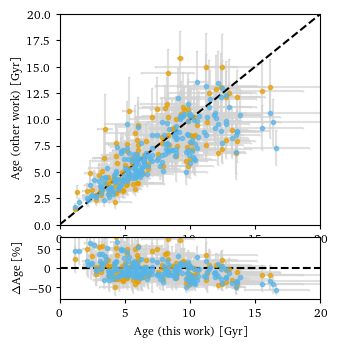

In [119]:
fig, axes = plt.subplot_mosaic('000\n000\n000\n111',
                               figsize=figsize(column='one', ratio=2*0.55))
#, squeeze=False, constrained_layout=True)
axes = list(axes.values())


for isuf, suf in enumerate(['_wu', '_miglio']):
    axes[0].errorbar(sample['age_m']/1e9, sample['age'+suf], 
                xerr=sample['e_age_m']/1e9, 
                yerr=sample['e_age'+suf],
                linestyle='none', marker='.', capsize=1, ecolor='lightgray', 
                color=colors[isuf], alpha=0.7)
    
    axes[1].errorbar(sample['age_m']/1e9, (sample['age'+suf]/(sample['age_m']/1e9)-1)*100, 
                xerr=sample['e_age_m']/1e9, 
                yerr=((sample['e_age'+suf]/sample['age'+suf])**2. + (sample['e_age_m']/sample['age_m'])**2.)**0.5 * sample['age'+suf]/(sample['age_m']/1e9) * 100,
                linestyle='none', marker='.', capsize=1, ecolor='lightgray',
                color=colors[isuf], alpha=0.7)


axes[0].plot([0, 20], [0, 20], color='k', linestyle='--')
axes[0].axis([0, 20, 0, 20])
axes[1].plot([0, 20], [0, 0], color='k', linestyle='--')
axes[1].axis([0, 20, -80, 80])


axes[0].set_ylabel('Age (other work) [Gyr]')
axes[1].set_xlabel('Age (this work) [Gyr]')
axes[1].set_ylabel(r'$\Delta$Age [\%]')


Text(0, 0.5, '$\\Delta$Mass [\\%]')

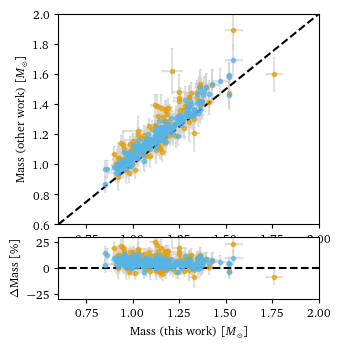

In [122]:
fig, axes = plt.subplot_mosaic('000\n000\n000\n111',
                               figsize=figsize(column='one', ratio=2*0.55))
#, squeeze=False, constrained_layout=True)
axes = list(axes.values())


for isuf, suf in enumerate(['_wu', '_miglio']):
    axes[0].errorbar(sample['mass_m'], sample['mass'+suf], 
                xerr=sample['e_mass_m'], yerr=sample['e_mass'+suf],
                linestyle='none', marker='.', capsize=1, ecolor='lightgray', 
                color=colors[isuf], alpha=0.7)
    
    axes[1].errorbar(sample['mass_m'], (sample['mass'+suf]/sample['mass_m']-1)*100, 
                xerr=sample['e_mass_m'], 
                yerr=((sample['e_mass'+suf]/sample['mass'+suf])**2. + (sample['e_mass_m']/sample['mass_m'])**2.)**0.5 * sample['mass'+suf]/(sample['mass_m']) * 100,
                linestyle='none', marker='.', capsize=1, ecolor='lightgray',
                color=colors[isuf], alpha=0.7)


axes[0].plot([0.6,2], [0.6,2], color='k', linestyle='--')
axes[0].axis([0.6,2,0.6,2])


axes[1].plot([0.6,2.0], [0,0], color='k', linestyle='--')
axes[1].axis([0.6, 2, -30, 30])


axes[0].set_ylabel(r'Mass (other work) [$M_\odot$]')
axes[1].set_xlabel(r'Mass (this work) [$M_\odot$]')
axes[1].set_ylabel(r'$\Delta$Mass [\%]')


In [37]:
# plt.hist((sample['age_miglio']-sample['age_m']/1e9)/sample['e_age_miglio'])
# print(np.std((sample['age_miglio']-sample['age_m']/1e9)/sample['e_age_miglio']))
# print(np.std((sample['age_miglio']-sample['age_m']/1e9)/(sample['e_age_m']/1e9)))
print(np.nanmean((sample['age_miglio']-sample['age_m']/1e9)/(sample['age_m']/1e9)))


# plt.hist((sample['age_wu']-sample['age_m']/1e9)/sample['e_age_wu'])
# print(np.std((sample['age_wu']-sample['age_m']/1e9)/sample['e_age_wu']))
# print(np.std((sample['age_wu']-sample['age_m']/1e9)/(sample['e_age_m']/1e9)))
print(np.nanmean((sample['age_wu']-sample['age_m']/1e9)/(sample['age_m']/1e9)))

-0.050468040211135594
0.043451835595763134


In [38]:
# plt.hist((sample['mass_miglio']-sample['mass_m'])/sample['e_mass_miglio'])
# print(np.std((sample['mass_miglio']-sample['mass_m'])/sample['e_mass_miglio']))
# print(np.std((sample['mass_miglio']-sample['mass_m'])/(sample['e_mass_m'])))
print(np.nanmean((sample['mass_miglio']-sample['mass_m'])/(sample['mass_m'])))


# plt.hist((sample['mass_wu']-sample['mass_m'])/sample['e_mass_wu'])
# print(np.std((sample['mass_wu']-sample['mass_m'])/sample['e_mass_wu']))
# print(np.std((sample['mass_wu']-sample['mass_m'])/(sample['e_mass_m'])))
print(np.nanmean((sample['mass_wu']-sample['mass_m'])/(sample['mass_m'])))

0.05214658125037578
0.0736584395457546


# with and without Teff constraints

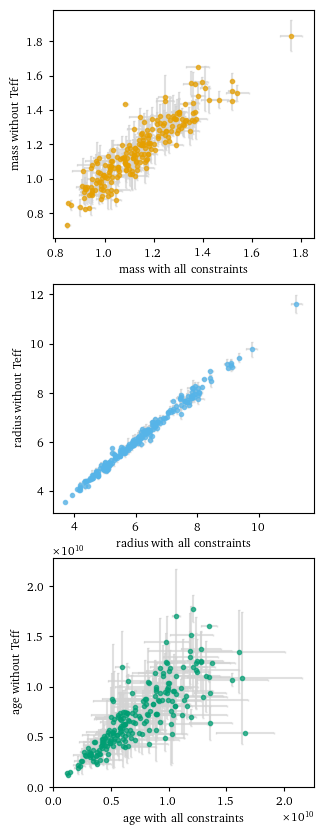

In [21]:
fig, axes = plt.subplot_mosaic('000\n111\n222',
                               figsize=figsize(column='one', ratio=3))
#, squeeze=False, constrained_layout=True)
axes = list(axes.values())


for iax, var in enumerate(['mass', 'radius', 'age']):
    axes[iax].errorbar(sample[var+'_m'], sample[var+'_mwt'], 
                xerr=sample['e_'+var+'_m'], yerr=sample['e_'+var+'_mwt'],
                linestyle='none', marker='.', capsize=1, ecolor='lightgray', 
                color=colors[iax], alpha=0.7)
    
    # axes[1].errorbar(sample['mass_m'], (sample['mass'+suf]/sample['mass_m']-1)*100, 
    #             xerr=sample['e_mass_m'], 
    #             yerr=((sample['e_mass'+suf]/sample['mass'+suf])**2. + (sample['e_mass_m']/sample['mass_m'])**2.)**0.5 * sample['mass'+suf]/(sample['mass_m']) * 100,
    #             linestyle='none', marker='.', capsize=1, ecolor='lightgray',
    #             color=colors[isuf], alpha=0.7)

    axes[iax].set_xlabel(var+' with all constraints')
    axes[iax].set_ylabel(var+' without Teff')


In [40]:
print(np.median((sample['age_mwt']-sample['age_m'])/(sample['age_m']))*100)
# print(np.median((sample['age_mwt']-sample['age_m'])/(sample['age_m'])))

print(np.median((sample['mass_mwt']-sample['mass_m'])/(sample['mass_m']))*100)
# print(np.median((sample['mass_mwt']-sample['mass_m'])/(sample['mass_m'])))

print(np.median((sample['radius_mwt']-sample['radius_m'])/(sample['radius_m']))*100)
# print(np.median((sample['radius_mwt']-sample['radius_m'])/(sample['radius_m'])))

-1.644866313561186
1.9334916959974289
0.6133120098923062
